In [17]:
from sklearn.model_selection import train_test_split
import pickle
import os
import h5py
from PIL import Image
import numpy as np
import datetime
import math
import random
import yaml
import argparse
import transforms3d
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Add, Flatten, Dense, concatenate, Rescaling, Normalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split


class DatasetLoader:
    def __init__(self, tfrecord_file, image_shape=[224, 224, 3], lasers_shape=513, goal_shape=2, motion_command_shape=3, reward_shape = 1):
        self.tfrecord_file = tfrecord_file
        self.image_shape = image_shape
        self.lasers_shape = lasers_shape
        self.goal_shape = goal_shape
        self.motion_command_shape = motion_command_shape
        self.reward_shape = reward_shape
        self.dataset_length = self._get_dataset_length()
        print(self.dataset_length)

    def _parse_with_lasers_function(self,proto):
        features = {
            'laser': tf.io.FixedLenFeature([self.lasers_shape], tf.float32),
            'goal': tf.io.FixedLenFeature([self.goal_shape], tf.float32),
            'motion_command': tf.io.FixedLenFeature([self.motion_command_shape], tf.float32),
            'reward': tf.io.FixedLenFeature([self.reward_shape], tf.float32),
        }
        parsed_features = tf.io.parse_single_example(proto, features)
        return  (parsed_features['laser'], parsed_features['goal'], parsed_features['motion_command']), parsed_features['reward']

    def _get_dataset_length(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        metadata_features = {
            'metadata': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'length': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
        }
        
        for record in dataset.take(1):
            parsed_features = tf.io.parse_single_example(record, metadata_features)
            dataset_length = parsed_features['length'].numpy()
            return dataset_length
        
        print("Metadata not found. Setting length to None.")
        return None

    def load_dataset(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        dataset = dataset.skip(1).map(self._parse_with_lasers_function, num_parallel_calls=tf.data.AUTOTUNE)
        return dataset


    def split_dataset(self, dataset, train_size=0.7, val_size=0.2):
        num_elements = self.dataset_length
        if num_elements is None:
            raise ValueError("Dataset length is not set. Ensure the metadata is properly included in the TFRecord.")
        
        train_end = int(train_size * num_elements)
        val_end = int((train_size + val_size) * num_elements)
        
        train_dataset = dataset.take(train_end)
        val_dataset = dataset.skip(train_end).take(val_end - train_end)
        test_dataset = dataset.skip(val_end).take(num_elements - val_end)
        
        return train_dataset, val_dataset, test_dataset

    def preprocess_and_augment(self, dataset_, batch_size=128):
        dataset_= dataset_.shuffle(buffer_size=10000).batch(batch_size)
        dataset_ = dataset_.prefetch(tf.data.AUTOTUNE)
        return dataset_

    def get_prepared_datasets(self, train_size=0.7, val_size=0.2, batch_size=128):
        dataset = self.load_dataset()
        
        train_dataset, val_dataset, test_dataset = self.split_dataset(dataset, train_size, val_size)
        del dataset
        train_dataset = self.preprocess_and_augment(train_dataset, batch_size)
        val_dataset = self.preprocess_and_augment(val_dataset, batch_size)
        test_dataset = self.preprocess_and_augment(test_dataset, batch_size)
        
        return train_dataset, val_dataset, test_dataset


class CustomExponentialDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate, minimum_learning_rate, staircase=True):
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        self.minimum_learning_rate = minimum_learning_rate
        self.staircase = staircase
        self.base_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
            staircase=staircase
        )

    def __call__(self, step):
        lr = self.base_schedule(step)
        return tf.maximum(lr, self.minimum_learning_rate)

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'decay_steps': self.decay_steps,
            'decay_rate': self.decay_rate,
            'minimum_learning_rate': self.minimum_learning_rate,
            'staircase': self.staircase
        }

class ModelCheckpointEveryN(Callback):
    def __init__(self, save_dir, model_name, save_freq=25):
        """
        A custom callback that saves the model every 'save_freq' epochs.
        
        :param save_dir: Directory to save the model.
        :param save_freq: Number of epochs between each save.
        """
        super(ModelCheckpointEveryN, self).__init__()
        self.save_dir = save_dir
        self.save_freq = save_freq
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs=None):
        # Save the model every 'save_freq' epochs
        if (epoch + 1) % self.save_freq == 0:
            model_save_path = os.path.join(self.save_dir, f"{self.model_name}_model_epoch_{epoch+1}.keras")
            print(f"\nEpoch {epoch+1}: Saving model to {model_save_path}")
            self.model.save(model_save_path)
            
class CriticModel_withLaser:
    def __init__(self, laser_shape, goal_shape, motion_command_shape, reward_shape, log_dir):
        self.laser_shape = laser_shape
        self.goal_shape = goal_shape
        self.motion_command_shape = motion_command_shape
        self.reward_shape = reward_shape
        self.log_dir = log_dir

        # Define normalization layers
        self.laser_normalization = Normalization()
        self.goal_normalization = Normalization()
        self.reward_normalization = Normalization()

        # Initialize the model
        self.model = self._create_model()
        
        
    
    def _create_model(self):
        """
        Creates a TensorFlow model for processing laser scans, goals, motion commands, and predicting rewards.
        
        :return: tf.keras.Model
        """
        # Define inputs
        laser_input = Input(shape=(self.laser_shape,), name='laser_input')
        goal_input = Input(shape=(self.goal_shape,), name='goal_input')
        motion_command_input = Input(shape=(self.motion_command_shape,), name='motion_command_input')
    
        # Optional normalization
        laser_normalized = self.laser_normalization(laser_input)
        goal_normalized = self.goal_normalization(goal_input)
        motion_command_normalized = self.reward_normalization(motion_command_input)
    
        # Laser processing
        laser_hidden = Dense(64, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(1e-4))(laser_normalized)
        laser_hidden = BatchNormalization()(laser_hidden)
        laser_hidden = LeakyReLU()(laser_hidden)
        laser_hidden = Dropout(0.2)(laser_hidden)
        laser_hidden = Dense(32, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(1e-4))(laser_hidden)
        laser_hidden = BatchNormalization()(laser_hidden)
        laser_hidden = LeakyReLU()(laser_hidden)
    
        # Goal processing
        goal_hidden = Dense(16, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(1e-4))(goal_normalized)
        goal_hidden = BatchNormalization()(goal_hidden)
        goal_hidden = LeakyReLU()(goal_hidden)
        goal_hidden = Dropout(0.2)(goal_hidden)
        goal_hidden = Dense(32, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(1e-4))(goal_hidden)
        goal_hidden = BatchNormalization()(goal_hidden)
        goal_hidden = LeakyReLU()(goal_hidden)
    
        # Motion command processing
        motion_command_hidden = Dense(8, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(1e-4))(motion_command_normalized)
        motion_command_hidden = BatchNormalization()(motion_command_hidden)
        motion_command_hidden = LeakyReLU()(motion_command_hidden)
        motion_command_hidden = Dropout(0.2)(motion_command_hidden)
        motion_command_hidden = Dense(32, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(1e-4))(motion_command_hidden)
        motion_command_hidden = BatchNormalization()(motion_command_hidden)
        motion_command_hidden = LeakyReLU()(motion_command_hidden)
    
        # Concatenate processed features
        concatenated = concatenate([laser_hidden, goal_hidden, motion_command_hidden])
    
        # Fully connected layers after concatenation
        hidden = Dense(32, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(1e-4))(concatenated)
        hidden = BatchNormalization()(hidden)
        hidden = LeakyReLU()(hidden)
        hidden = Dropout(0.2)(hidden)
        hidden = Dense(16, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(1e-4))(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = LeakyReLU()(hidden)
        hidden = Dropout(0.2)(hidden)
    
        # Output layer for reward
        output = Dense(1, activation='linear', name='reward_output')(hidden)
    
        # Create and return the model
        model = Model(inputs=[laser_input, goal_input, motion_command_input], outputs=output)
        return model

   


    def compile_model(self, initial_learning_rate=0.005, decay_steps=5000, decay_rate=0.96, minimum_learning_rate=0.001):
        lr_schedule = CustomExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
            minimum_learning_rate=minimum_learning_rate)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    class PrintLearningRateCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            lr = self.model.optimizer.learning_rate
            if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
                lr = lr(self.model.optimizer.iterations)
            print(f"\nEpoch {epoch+1}: Learning rate is {tf.keras.backend.eval(lr)}")
    

    def train_model(self, train_dataset, val_dataset, epochs, train_steps, val_steps, initial_learning_rate, decay_steps,
                    decay_rate, minimum_learning_rate, model_save_path, model_name):
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=self.log_dir, histogram_freq=1)
        model_checkpoint_callback = ModelCheckpointEveryN(save_dir=model_save_path, model_name=model_name, save_freq=25)
        self.compile_model(initial_learning_rate, decay_steps, decay_rate, minimum_learning_rate)
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=val_dataset,
            steps_per_epoch=train_steps,  # Specify steps per epoch for training
            validation_steps=val_steps,
            verbose=1,
            callbacks=[self.PrintLearningRateCallback(), tensorboard_callback, model_checkpoint_callback]
        )
        return history


def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config


    
# Load the configuration
config = load_config('/work/nselva2s/rnd/repo/src/Reinforcement_Learning/config_critic_laser.yaml')

root_dir = config['root_dir']
tf_file = os.path.join(root_dir, config['tfrecord_file'])
log_dir = config['log_dir'] +datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(root_dir, log_dir)
model_save_path = os.path.join(root_dir, config['model_save_path'])
model_name = config['model_name']

loader = DatasetLoader(tf_file)
train_dataset, val_dataset, test_dataset = loader.get_prepared_datasets(train_size = config['train_size'], val_size = config['val_size'],
                                                                       batch_size = config['batch_size'])

print('Training, validation, and test datasets created and preprocessed.')








432516
Training, validation, and test datasets created and preprocessed.


In [18]:
laser_shape = 513
goal_shape = 2
motion_command_shape = 3
reward_shape = 1

model_instance = CriticModel_withLaser(laser_shape, goal_shape, motion_command_shape, reward_shape, log_dir)
history = model_instance.train_model(train_dataset, val_dataset, epochs=config['epochs'],
                                     train_steps = config['train_steps'], val_steps = config['val_steps'],
                                    initial_learning_rate = config['initial_learning_rate'], decay_steps = config['decay_steps'],
                                     decay_rate = config['decay_rate'], minimum_learning_rate = config['minimum_learning_rate'],
                                    model_save_path = model_save_path, model_name = model_name)

print("Model training complete.")

Epoch 1/50
2296/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 29.9493 - mae: 4.3119 

2025-01-15 13:29:25.979129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:29:26.684557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 1: Learning rate is 9.999999747378752e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - loss: 29.9388 - mae: 4.3110 - val_loss: 16.6304 - val_mae: 3.1293
Epoch 2/50
  61/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 19.4968 - mae: 3.3902 
Epoch 2: Learning rate is 9.999999747378752e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step - loss: 19.8691 - mae: 3.4111 - val_loss: 16.5125 - val_mae: 3.0850
Epoch 3/50
2294/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.8083 - mae: 3.3060 

2025-01-15 13:30:21.629494: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:30:22.353675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 3: Learning rate is 8.999999408842996e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 18.8064 - mae: 3.3058 - val_loss: 13.9732 - val_mae: 2.7801
Epoch 4/50
  59/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 17.4499 - mae: 3.1464 
Epoch 4: Learning rate is 8.999999408842996e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 244us/step - loss: 17.9736 - mae: 3.1979 - val_loss: 13.9298 - val_mae: 2.8020
Epoch 5/50
2288/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6412 - mae: 3.0760 

2025-01-15 13:31:17.045144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:31:17.761765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 5: Learning rate is 8.999999408842996e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - loss: 16.6391 - mae: 3.0758 - val_loss: 12.9709 - val_mae: 2.6455
Epoch 6/50
  58/2300 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 16.2061 - mae: 3.0267 
Epoch 6: Learning rate is 8.999999408842996e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step - loss: 15.5815 - mae: 2.9742 - val_loss: 12.9945 - val_mae: 2.6268
Epoch 7/50
2299/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15.3860 - mae: 2.9364 

2025-01-15 13:32:12.680935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:32:13.394498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 7: Learning rate is 8.099999104160815e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 15.3858 - mae: 2.9364 - val_loss: 11.9554 - val_mae: 2.5122
Epoch 8/50
  58/2300 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 15.6265 - mae: 2.9519 
Epoch 8: Learning rate is 8.099999104160815e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - loss: 14.9108 - mae: 2.8948 - val_loss: 12.1131 - val_mae: 2.5473
Epoch 9/50
2288/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.5798 - mae: 2.8441 

2025-01-15 13:33:07.124726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:33:07.791725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 9: Learning rate is 8.099999104160815e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - loss: 14.5787 - mae: 2.8440 - val_loss: 11.8332 - val_mae: 2.4665
Epoch 10/50
  61/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 14.3777 - mae: 2.8251 
Epoch 10: Learning rate is 8.099999104160815e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step - loss: 14.2800 - mae: 2.8144 - val_loss: 11.4915 - val_mae: 2.4238
Epoch 11/50
2287/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13.8225 - mae: 2.7614 

2025-01-15 13:34:02.480929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:34:03.197160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 11: Learning rate is 7.289998757187277e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 13.8219 - mae: 2.7613 - val_loss: 10.9779 - val_mae: 2.3588
Epoch 12/50
  53/2300 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 14.0484 - mae: 2.7834  
Epoch 12: Learning rate is 7.289998757187277e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step - loss: 13.8094 - mae: 2.7644 - val_loss: 11.3886 - val_mae: 2.4135
Epoch 13/50
2288/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 13.3988 - mae: 2.7085 

2025-01-15 13:34:56.496118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:34:57.174996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 13: Learning rate is 7.289998757187277e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - loss: 13.3981 - mae: 2.7084 - val_loss: 10.6238 - val_mae: 2.3008
Epoch 14/50
  61/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 13.6290 - mae: 2.7094 
Epoch 14: Learning rate is 7.289998757187277e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 248us/step - loss: 13.0742 - mae: 2.6653 - val_loss: 10.7423 - val_mae: 2.3161
Epoch 15/50
2287/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.9001 - mae: 2.6451 

2025-01-15 13:35:50.870056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:35:51.570191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 15: Learning rate is 6.560998735949397e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - loss: 12.8998 - mae: 2.6451 - val_loss: 10.4437 - val_mae: 2.2633
Epoch 16/50
  60/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 12.5161 - mae: 2.5980 
Epoch 16: Learning rate is 6.560998735949397e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - loss: 12.6394 - mae: 2.6158 - val_loss: 10.9923 - val_mae: 2.3214
Epoch 17/50
2287/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.6145 - mae: 2.6125 

2025-01-15 13:36:45.769895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:36:46.485016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 17: Learning rate is 6.560998735949397e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - loss: 12.6138 - mae: 2.6124 - val_loss: 10.1801 - val_mae: 2.2221
Epoch 18/50
  59/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 12.2398 - mae: 2.5853 
Epoch 18: Learning rate is 6.560998735949397e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step - loss: 12.5538 - mae: 2.6117 - val_loss: 10.2905 - val_mae: 2.2242
Epoch 19/50
2296/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.2526 - mae: 2.5675 

2025-01-15 13:37:41.013457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:37:41.738672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 19: Learning rate is 5.904899080633186e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 12.2525 - mae: 2.5675 - val_loss: 10.3022 - val_mae: 2.2245
Epoch 20/50
  56/2300 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 12.0152 - mae: 2.5659 
Epoch 20: Learning rate is 5.904899080633186e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 265us/step - loss: 12.0595 - mae: 2.5666 - val_loss: 9.8993 - val_mae: 2.1928
Epoch 21/50
2293/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.9737 - mae: 2.5339 

2025-01-15 13:38:36.443127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:38:37.161976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 21: Learning rate is 5.904899080633186e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 11.9736 - mae: 2.5338 - val_loss: 9.5945 - val_mae: 2.1309
Epoch 22/50
  56/2300 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 11.6284 - mae: 2.4999 
Epoch 22: Learning rate is 5.904899080633186e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 254us/step - loss: 11.9170 - mae: 2.5216 - val_loss: 10.2177 - val_mae: 2.1923
Epoch 23/50
2297/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.7625 - mae: 2.5029 

2025-01-15 13:39:32.579468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:39:33.294772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 23: Learning rate is 5.314408917911351e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 11.7625 - mae: 2.5029 - val_loss: 9.7652 - val_mae: 2.1437
Epoch 24/50
  59/2300 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 11.4391 - mae: 2.4549 
Epoch 24: Learning rate is 5.314408917911351e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - loss: 11.5324 - mae: 2.4776 - val_loss: 10.0501 - val_mae: 2.1651
Epoch 25/50
2287/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.6100 - mae: 2.4833 

2025-01-15 13:40:26.531854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:40:27.214694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 25: Learning rate is 5.314408917911351e-05

Epoch 25: Saving model to /work/nselva2s/rnd/ReinforcementLearning_models/critic_laser_corr07112024_a_model_epoch_25.keras
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - loss: 11.6098 - mae: 2.4832 - val_loss: 9.7276 - val_mae: 2.1379
Epoch 26/50
  53/2300 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 11.2570 - mae: 2.4500 
Epoch 26: Learning rate is 5.314408917911351e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step - loss: 11.4297 - mae: 2.4719 - val_loss: 9.7286 - val_mae: 2.1347
Epoch 27/50
2287/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.3547 - mae: 2.4511 

2025-01-15 13:41:21.215388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:41:21.918942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 27: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - loss: 11.3549 - mae: 2.4511 - val_loss: 9.2027 - val_mae: 2.0699
Epoch 28/50
  58/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 11.4099 - mae: 2.4649 
Epoch 28: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step - loss: 11.4434 - mae: 2.4727 - val_loss: 10.1162 - val_mae: 2.1507
Epoch 29/50
2289/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.2632 - mae: 2.4354 

2025-01-15 13:42:15.545390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:42:16.248988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 29: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - loss: 11.2631 - mae: 2.4354 - val_loss: 9.3052 - val_mae: 2.0654
Epoch 30/50
  57/2300 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 11.2647 - mae: 2.4508 
Epoch 30: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - loss: 11.4028 - mae: 2.4601 - val_loss: 9.4080 - val_mae: 2.0659
Epoch 31/50
2298/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.0639 - mae: 2.4131 

2025-01-15 13:43:10.433029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:43:11.134089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 31: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - loss: 11.0640 - mae: 2.4131 - val_loss: 9.0760 - val_mae: 2.0428
Epoch 32/50
  58/2300 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 10.6899 - mae: 2.3820 
Epoch 32: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step - loss: 10.6696 - mae: 2.3746 - val_loss: 8.9940 - val_mae: 2.0291
Epoch 33/50
2290/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.9521 - mae: 2.3966 

2025-01-15 13:44:04.705188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:44:05.410699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 33: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - loss: 10.9521 - mae: 2.3965 - val_loss: 8.9811 - val_mae: 2.0192
Epoch 34/50
  60/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 11.1225 - mae: 2.4248 
Epoch 34: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 10.7741 - mae: 2.3864 - val_loss: 9.0980 - val_mae: 2.0254
Epoch 35/50
2299/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.7940 - mae: 2.3736 

2025-01-15 13:44:59.846186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:45:00.566767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 35: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - loss: 10.7940 - mae: 2.3736 - val_loss: 9.2010 - val_mae: 2.0373
Epoch 36/50
  61/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 10.5623 - mae: 2.3569
Epoch 36: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 257us/step - loss: 10.9620 - mae: 2.3935 - val_loss: 8.9864 - val_mae: 2.0214
Epoch 37/50
2293/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.6844 - mae: 2.3613 

2025-01-15 13:45:54.458740: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:45:55.150684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 37: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - loss: 10.6844 - mae: 2.3613 - val_loss: 8.9322 - val_mae: 2.0081
Epoch 38/50
  59/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 10.7747 - mae: 2.3590 
Epoch 38: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 262us/step - loss: 10.7942 - mae: 2.3649 - val_loss: 8.5837 - val_mae: 1.9634
Epoch 39/50
2292/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.5913 - mae: 2.3445 

2025-01-15 13:46:49.470390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:46:50.183973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 39: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - loss: 10.5911 - mae: 2.3444 - val_loss: 8.8030 - val_mae: 1.9768
Epoch 40/50
  60/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 10.6907 - mae: 2.3673 
Epoch 40: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step - loss: 10.4814 - mae: 2.3423 - val_loss: 8.9156 - val_mae: 1.9836
Epoch 41/50
2293/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.4027 - mae: 2.3206 

2025-01-15 13:47:45.460380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:47:46.179925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 41: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 10.4029 - mae: 2.3206 - val_loss: 8.4194 - val_mae: 1.9321
Epoch 42/50
  60/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 11.2171 - mae: 2.4082 
Epoch 42: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 255us/step - loss: 10.8412 - mae: 2.3623 - val_loss: 8.7767 - val_mae: 1.9632
Epoch 43/50
2289/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.3331 - mae: 2.3095 

2025-01-15 13:48:41.017701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:48:41.722386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 43: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 10.3333 - mae: 2.3095 - val_loss: 8.3746 - val_mae: 1.9199
Epoch 44/50
  59/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 10.3101 - mae: 2.3174 
Epoch 44: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 267us/step - loss: 10.3139 - mae: 2.2994 - val_loss: 8.8355 - val_mae: 1.9791
Epoch 45/50
2294/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.2189 - mae: 2.2903 

2025-01-15 13:49:37.221053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:49:37.945606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 45: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step - loss: 10.2189 - mae: 2.2903 - val_loss: 8.4270 - val_mae: 1.9262
Epoch 46/50
  61/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 10.6152 - mae: 2.3376
Epoch 46: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 261us/step - loss: 10.4163 - mae: 2.3228 - val_loss: 8.5683 - val_mae: 1.9334
Epoch 47/50
2292/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.1389 - mae: 2.2814 

2025-01-15 13:50:32.756916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:50:33.477099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 47: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 10.1389 - mae: 2.2814 - val_loss: 7.8252 - val_mae: 1.8483
Epoch 48/50
  61/2300 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 10.3370 - mae: 2.2875 
Epoch 48: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 245us/step - loss: 10.1590 - mae: 2.2646 - val_loss: 8.1493 - val_mae: 1.8768
Epoch 49/50
2287/2300 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.0204 - mae: 2.2628 

2025-01-15 13:51:28.921288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:174: Filling up shuffle buffer (this may take a while): 1 of 10000
2025-01-15 13:51:29.624453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.



Epoch 49: Learning rate is 4.999999873689376e-05
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 55s 24ms/step - loss: 10.0206 - mae: 2.2629 - val_loss: 8.4053 - val_mae: 1.9159
Epoch 50/50
  57/2300 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 10.6114 - mae: 2.3101 
Epoch 50: Learning rate is 4.999999873689376e-05

Epoch 50: Saving model to /work/nselva2s/rnd/ReinforcementLearning_models/critic_laser_corr07112024_a_model_epoch_50.keras
2300/2300 ━━━━━━━━━━━━━━━━━━━━ 1s 292us/step - loss: 10.2324 - mae: 2.2737 - val_loss: 8.5877 - val_mae: 1.9236
Model training complete.


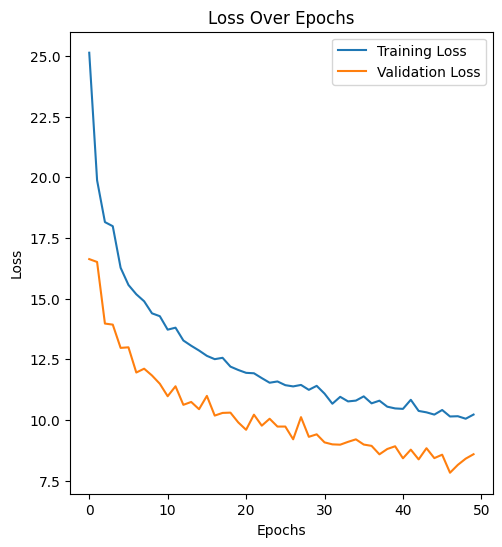

In [19]:
plt.figure(figsize=(12, 6))
            
# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [20]:
model_instance.model.evaluate(test_dataset)

2025-01-15 13:52:05.806585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:177: Filling up shuffle buffer (this may take a while): 1 of 10000


     19/Unknown 31s 10ms/step - loss: 8.1383 - mae: 1.8727

2025-01-15 13:52:06.660859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


338/338 ━━━━━━━━━━━━━━━━━━━━ 33s 8ms/step - loss: 8.1820 - mae: 1.8852


[8.270221710205078, 1.8954498767852783]

In [21]:
model_instance.model.predict(test_dataset.take(1))

2025-01-15 13:52:38.347034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:177: Filling up shuffle buffer (this may take a while): 1 of 10000


1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step


2025-01-15 13:52:39.084476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


array([[  4.433696  ],
       [  0.321082  ],
       [ -0.75123817],
       [  2.59642   ],
       [  2.384208  ],
       [  4.2870617 ],
       [-11.425433  ],
       [ -1.1228578 ],
       [-10.394135  ],
       [ -1.8157618 ],
       [  0.87029344],
       [  4.791887  ],
       [  3.7342956 ],
       [ -3.0285933 ],
       [ -2.4419835 ],
       [-16.850103  ],
       [  3.8386917 ],
       [  3.2029197 ],
       [  4.38576   ],
       [  2.8069556 ],
       [ -4.290981  ],
       [ -1.8873291 ],
       [  4.1744766 ],
       [ -0.70655996],
       [  0.97594786],
       [ -1.8157618 ],
       [  4.383082  ],
       [ -2.5893528 ],
       [ -9.565497  ],
       [  1.3902547 ],
       [  1.1069243 ],
       [ -9.195109  ],
       [-11.289326  ],
       [  3.4819803 ],
       [ -1.0458578 ],
       [-10.884254  ],
       [  3.6354873 ],
       [ -4.518933  ],
       [  4.2395444 ],
       [  3.800515  ],
       [ -5.965018  ],
       [  3.0223258 ],
       [  2.177088  ],
       [  2